In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Load the data
def loadData():
    with np.load("notMNIST.npz") as data:
        Data, Target = data["images"], data["labels"]
        np.random.seed(521)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data = Data[randIndx] / 255.0
        Target = Target[randIndx]
        trainData, trainTarget = Data[:10000], Target[:10000]
        validData, validTarget = Data[10000:16000], Target[10000:16000]
        testData, testTarget = Data[16000:], Target[16000:]
    return trainData, validData, testData, trainTarget, validTarget, testTarget

# Implementation of a neural network using only Numpy - trained using gradient descent with momentum
def convertOneHot(trainTarget, validTarget, testTarget):
    newtrain = np.zeros((trainTarget.shape[0], 10))
    newvalid = np.zeros((validTarget.shape[0], 10))
    newtest = np.zeros((testTarget.shape[0], 10))

    for item in range(0, trainTarget.shape[0]):
        newtrain[item][trainTarget[item]] = 1
    for item in range(0, validTarget.shape[0]):
        newvalid[item][validTarget[item]] = 1
    for item in range(0, testTarget.shape[0]):
        newtest[item][testTarget[item]] = 1
    return newtrain, newvalid, newtest

def shuffle(trainData, trainTarget):
    np.random.seed(421)
    randIndx = np.arange(len(trainData))
    target = trainTarget
    np.random.shuffle(randIndx)
    data, target = trainData[randIndx], target[randIndx]
    return data, target


def convolutional_layers(features, labels):
    # Input Layer
    input = tf.reshape(features, shape=[-1, 28, 28, 1])
    # 3x3 convolution, 1 input, 32 outputs
    W1 = tf.get_variable("W1", [3, 3, 1, 32], dtype='float32',initializer=tf.contrib.layers.xavier_initializer())
    b1 = tf.get_variable('b1', [32], dtype='float32', initializer=tf.contrib.layers.xavier_initializer())
    conv = tf.nn.conv2d(input, W1, strides=[1, 1, 1, 1], padding='SAME')

    conv1 = tf.nn.relu(conv + b1, name='conv1')

    # Batch Normalization layer
    mean, variance = tf.nn.moments(conv1, axes=[0, 1, 2])
    bn = tf.nn.batch_normalization(x=conv1, mean=mean, variance=variance, offset=None, scale=None, variance_epsilon=0.001)

    # 2×2 max pooling layer
    pool = tf.nn.max_pool(bn, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Flatten Layer
    pool = tf.reshape(pool, [-1, 6272])

    # Fully connected layer relu
    W2 = tf.get_variable('W2', [6272, 1024], dtype='float32', initializer=tf.contrib.layers.xavier_initializer())
    b2 = tf.get_variable('b2', [1024], dtype='float32', initializer=tf.contrib.layers.xavier_initializer())
    fc1 = tf.nn.relu(tf.matmul(pool, W2) + b2)

    # Fully connected layer with softmax
    W3 = tf.get_variable('W3', [1024, 10], dtype='float32', initializer=tf.contrib.layers.xavier_initializer())
    b3 = tf.get_variable('b3', [10], dtype='float32', initializer=tf.contrib.layers.xavier_initializer())
    #sm = tf.get_variable('sm', [labels[0].shape, labels[1].shape], dtype='float64', initializer=tf.contrib.layers.xavier_initializer())
    fc2 = tf.matmul(fc1, W3) + b3
    sm = tf.nn.softmax(fc2)
    acc, acc_op = tf.metrics.accuracy(labels=tf.argmax(sm, 1), predictions=tf.argmax(labels, 1))

    # Loss with cross entropy
    entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels, logits=fc2)
    loss = tf.reduce_mean(entropy)

    return loss, W3, b3, acc_op

def Model_Training(features, labels):

    dim = 10
    N = features.shape[0]
    dim_x = features.shape[1]
    dim_y = features.shape[2]
    batch_size = 32
    epoch = 50
    runs = int(N / batch_size)

    # Define placeholders to feed mini_batches
    X = tf.placeholder(tf.float32, shape=(batch_size, dim_x * dim_y), name="X")
    Y = tf.placeholder(tf.float32, shape=(batch_size, None), name="Y")
    lam = tf.placeholder(tf.float32, shape=None, name="lam")

    loss, W, b, accer = convolutional_layers(X, Y)

    opt = tf.train.AdamOptimizer(0.0001).minimize(loss)

    return W, b, Y, X, loss, opt, accer, lam

def Model_Batches(it, x_data, y_data, batch_size, session, X, Y, opt, loss, accer, type, lam, reg):
    a_acc=0
    a_l=0
    for p in range(int(it/10)):
        x_batch = x_data[p * batch_size:(p + 1) * batch_size].reshape((batch_size, x_data.shape[1] * x_data.shape[2]))
        y_batch = y_data[p * batch_size:(p + 1) * batch_size]
        if type == 'train':
            _, l, acc = session.run([opt, loss, accer], feed_dict={X: x_batch, Y: y_batch, lam:reg})
        else:
            l, acc = session.run([loss, accer], feed_dict={X: x_batch, Y: y_batch, lam:reg})
        print(l,acc)
        a_acc += acc
        a_l += l
    a_acc/=int(it/10)
    a_l/=int(it/10)
    return a_l, a_acc

def BuildGraphs(batchSize, iterations):

    trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()
    trainTarget, validTarget, testTarget = convertOneHot(trainTarget, validTarget, testTarget)

    W, b, Y, X, loss, train_op, accer, lam = Model_Training(trainData, trainTarget)

    l_train = []
    l_valid = []
    l_test = []
    a_train = []
    a_valid = []
    a_test = []
    trainBatches = int(trainData.shape[0] / batchSize)
    validBatches = int(validData.shape[0] / batchSize)
    testBatches = int(testData.shape[0] / batchSize)
    error_valid = 0
    error_test = 0
    acc_valid = 0
    acc_test = 0
    reg = 0

    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        session.run(tf.local_variables_initializer())

        #sess.run(tf.global_variables_initializer())
        for i in range(iterations):
            print(str(i)+"-------------------------------")
            i_train = np.arange(trainData.shape[0])
            np.random.shuffle(i_train)
            i_valid = np.arange(validData.shape[0])
            np.random.shuffle(i_valid)
            i_test = np.arange(testData.shape[0])
            np.random.shuffle(i_test)

            trainData = trainData[i_train]
            validData = validData[i_valid]
            testData = testData[i_test]

            trainTarget = trainTarget[i_train]
            validTarget = validTarget[i_valid]
            testTarget = testTarget[i_test]

            error_train, acc_train = Model_Batches(trainBatches, trainData, trainTarget, \
                          batchSize, session, X, Y, train_op, loss, accer, 'train', lam, reg)
            error_valid, acc_valid = Model_Batches(validBatches, validData, validTarget, \
                          batchSize, session, X, Y, train_op, loss, accer, 'valid', lam, reg)
            error_test, acc_test = Model_Batches(testBatches, testData, testTarget, \
                          batchSize, session, X, Y, train_op, loss, accer, 'test', lam, reg)

            l_train.append(error_train)
            l_valid.append(error_valid)
            l_test.append(error_test)

            a_train.append(acc_train)
            a_valid.append(acc_valid)
            a_test.append(acc_test)
    return l_train, l_valid, l_test, a_train, a_valid, a_test

In [2]:
trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()
trainTarget, validTarget, testTarget = convertOneHot(trainTarget, validTarget, testTarget)
l_tr, l_v, l_t, a_tr, a_v, a_t = BuildGraphs(32, 50)

0-------------------------------
2.480797 0.25
1.963562 0.28125
1.4096166 0.35416666
1.2585464 0.390625
1.1423056 0.425
0.937768 0.46875
0.7493946 0.5089286
1.1248183 0.52734375
0.988325 0.5451389
0.62161344 0.56875
0.70074487 0.59090906
0.38598233 0.6145833
0.6652923 0.62740386
0.45646158 0.64508927
1.0511494 0.6479167
0.44938365 0.6621094
1.0951029 0.6691176
0.6636198 0.6805556
0.5706471 0.68914473
0.654258 0.69375
0.79681456 0.6994048
0.90223706 0.70170456
0.5651089 0.70788044
0.69599384 0.7135417
0.8394415 0.715
0.951388 0.7139423
0.74101794 0.7199074
0.59096485 0.72321427
0.6585583 0.7241379
0.5617862 0.725
0.42846137 0.73084676
0.60610336 0.7324219
0.4335133 0.73674244
0.4848708 0.74080884
0.42329967 0.74464285
0.38810396 0.75
0.443305 0.7533784
0.41889852 0.7565789
0.40184706 0.75961536
0.49110317 0.76171875
0.25966612 0.7660061
0.5151843 0.76785713
0.50879204 0.7696221
0.117422074 0.77414775
0.6968887 0.775
0.36894947 0.77717394
0.26382586 0.7799202
0.73277617 0.77994794
0.4095

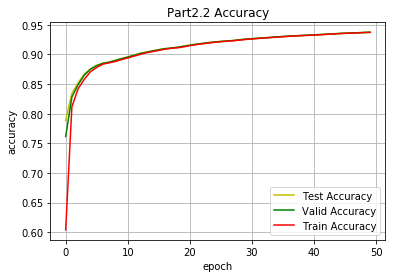

In [3]:
plt.figure(0)
plt.title("Part2.2 Accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.plot(range(len(a_t)), a_t, 'y-', label="Test Accuracy")
plt.plot(range(len(a_v)), a_v, 'g-', label="Valid Accuracy")
plt.plot(range(len(a_tr)), a_tr,'r-', label="Train Accuracy")
plt.grid()
plt.legend()

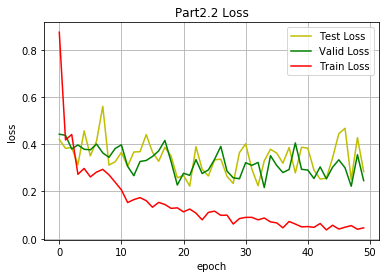

In [4]:
plt.figure(0)
plt.title("Part2.2 Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(range(len(l_t)), l_t, 'y-', label="Test Loss")
plt.plot(range(len(l_v)), l_v, 'g-', label="Valid Loss")
plt.plot(range(len(l_tr)), l_tr,'r-', label="Train Loss")
plt.grid()
plt.legend()